# 0.**Librerias**

In [1]:
!pip install -U torch --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate datasets bitsandbytes triton peft trl \
    bert-score textstat numpy pandas
# ===============================
# ✅ LIMPIEZA DE SALIDA Y VERIFICACIÓN DE VERSIONES
# ===============================
import IPython
IPython.display.clear_output(wait=True)

Looking in indexes: https://download.pytorch.org/whl/cu121
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 362, in run
    resolver = self.make_resolver(
               ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 177, in make_resolver
    return pip._internal.resolution.resolvelib.resolver.Resolver(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 58, in __init__
    self.factory = Fac

In [ ]:
import torch, transformers, peft, trl, accelerate, bitsandbytes, datasets

print("✅ Librerías cargadas correctamente:\n")
print(f"PyTorch:        {torch.__version__}")
print(f"Transformers:   {transformers.__version__}")
print(f"PEFT:           {peft.__version__}")
print(f"TRL:            {trl.__version__}")
print(f"Accelerate:     {accelerate.__version__}")
print(f"Datasets:       {datasets.__version__}")
print(f"BitsAndBytes:   {bitsandbytes.__version__}")

print("\n✨ Entorno listo para QLoRA 4-bit + SFTTrainer + TRL 0.24.0 ✨")

✅ Librerías cargadas correctamente:

PyTorch:        2.8.0+cu126
Transformers:   4.57.1
PEFT:           0.17.1
TRL:            0.24.0
Accelerate:     1.11.0
Datasets:       4.4.1
BitsAndBytes:   0.48.2

✨ Entorno listo para QLoRA 4-bit + SFTTrainer + TRL 0.24.0 ✨


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Crear carpeta y entrar
!mkdir cochrane_data
%cd cochrane_data

# 2. Inicializar git vacío
!git init

# 3. Agregar remote
!git remote add -f origin https://github.com/feliperussi/bridging-the-gap-in-health-literacy.git

# 4. Activar modo sparse checkout
!git config core.sparseCheckout true

# 5. Indicar SOLO las carpetas que queremos
!echo "data_collection_and_processing/Data Sources/Cochrane/train/pls" >> .git/info/sparse-checkout
!echo "data_collection_and_processing/Data Sources/Cochrane/train/non_pls" >> .git/info/sparse-checkout

# 6. Descargar solo esa parte del repo
!git pull origin main


/content/cochrane_data/cochrane_data
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/cochrane_data/cochrane_data/.git/
Updating origin
remote: Enumerating objects: 72074, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72074 (delta 0), reused 2 (delta 0), pack-reused 72071 (from 2)
Receiving objects: 100% (72074/72074), 315.90 MiB | 15.74 MiB/s, done.
Resolving deltas: 100% (2991/2991), done.
From https://github.com/feliperussi/bridging-the-gap-in-hea

Gestionar Hugging Face

In [ ]:
import os
os.environ["HF_TOKEN"] = "hf"

In [ ]:
from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model
import glob, pandas as pd
import transformers, trl, peft, accelerate, datasets
import bitsandbytes as bnb
import re

# 1.Construir el dataset non_pls → pls desde las carpetas de GitHub

In [ ]:
# Número máximo de pares
pares = 1000

# === 1️⃣ Listar archivos ===
pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/pls/*.txt"))
non_pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/non_pls/*.txt"))

# === 2️⃣ Filtrar non-PLS que contengan 'accumulated' ===
non_pls_files = [f for f in non_pls_files if "accumulated" not in os.path.basename(f).lower()]

print(f"📚 Total PLS: {len(pls_files)}")
print(f"📂 Total non-PLS (sin 'accumulated'): {len(non_pls_files)}")

# === 3️⃣ Función para extraer el ID base (hasta antes de 'pub') ===
def extract_id(filename):
    """
    Extrae el identificador base del archivo hasta antes de 'pub'.
    Ejemplo:
      10.1002-14651858.CD000371.pub7-abstract.txt → 10.1002-14651858.CD000371
    """
    base = os.path.basename(filename)
    match = re.match(r"(.+?)\.pub\d+", base)
    return match.group(1) if match else base.split(".txt")[0]

# === 4️⃣ Crear diccionarios {id_base: ruta} ===
pls_dict = {extract_id(p): p for p in pls_files}
non_pls_dict = {extract_id(n): n for n in non_pls_files}

# === 5️⃣ Emparejar por ID base ===
data = []
for base_id, non_path in non_pls_dict.items():
    if base_id in pls_dict:
        pls_path = pls_dict[base_id]
        with open(pls_path, "r", encoding="utf-8") as f1, open(non_path, "r", encoding="utf-8") as f2:
            data.append({
                "id": base_id,
                "file_pls": os.path.basename(pls_path),
                "file_non_pls": os.path.basename(non_path),
                "pls": f1.read().strip(),
                "non_pls": f2.read().strip()
            })
    if len(data) >= pares:
        break

# === 6️⃣ Crear DataFrame ===
df = pd.DataFrame(data)

# === 7️⃣ Guardar resultados ===
output_path = "cochrane_pairs_clean.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"\n✅ Emparejados {len(df)} pares por nombre base (sin 'accumulated')")
print(f"💾 Guardado en: {output_path}")
df.head(3)



📚 Total PLS: 16241
📂 Total non-PLS (sin 'accumulated'): 7251

✅ Emparejados 1000 pares por nombre base (sin 'accumulated')
💾 Guardado en: cochrane_pairs_clean.csv


,id,file_pls,file_non_pls,pls,non_pls
0,10.1002-14651858.CD000006,10.1002-14651858.CD000006.pub2-pls.txt,10.1002-14651858.CD000006.pub2-abstract.txt,Absorbable stitches for repair of episiotomy a...,Background\nApproximately 70% of women will ex...
1,10.1002-14651858.CD000009,10.1002-14651858.CD000009.pub4-pls.txt_accumul...,10.1002-14651858.CD000009.pub4-abstract.txt_se...,Do acupuncture and related therapies help smok...,We included 38 studies. Based on three studies...
2,10.1002-14651858.CD000012,10.1002-14651858.CD000012.pub4-pls.txt,10.1002-14651858.CD000012.pub4-abstract.txt_se...,Alternative versus conventional institutional ...,"Ten trials involving 11,795 women met the incl..."


# 2.Test,train split y generacion del prompt

In [ ]:
df = df.rename(columns={"non_pls": "source", "pls": "target"})

INSTR_PROMPT = """Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract:

{source}

### Output PLS:
"""

def format_example(row):
    prompt = INSTR_PROMPT.format(source=row["source"])
    return {"prompt": prompt, "response": row["target"]}

# Aplicar la función a cada fila del DataFrame
dataset = df.apply(format_example, axis=1).to_list()

# Crear Dataset de Hugging Face y dividir en train/test
from datasets import Dataset

hf_ds = Dataset.from_list(dataset).train_test_split(test_size=0.1, seed=42)

print(hf_ds)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'response'],
        num_rows: 900
    })
    test: Dataset({
        features: ['prompt', 'response'],
        num_rows: 100
    })
})


## Mostrar uno al azar

In [ ]:
import random

idx = random.randint(0, len(hf_ds["train"]) - 1)
print(f"🔹 Ejemplo #{idx}")
print(hf_ds["train"][idx]["prompt"])

🔹 Ejemplo #654
Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract:

Background
Advances in embryo culture media have led to a shift in in vitro fertilisation (IVF) practice from cleavage‐stage embryo transfer to blastocyst‐stage embryo transfer. T

# 3.Training del Modelo (Modelo Base + QLoRA)

version Llama

In [ ]:
MODELO="meta-llama/Llama-3.2-1B"
num_train_epochs=5
COSINE_WEIGHT=0  #0.05
KL_WEIGHT=0    #0.05
base_model_name="meta-llama/Llama-3.2-1B" #teacher

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForSeq2Seq, BitsAndBytesConfig, AutoModel,TrainingArguments
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import os
import sys
import torch
from torch import nn
from transformers import Trainer, TrainingArguments


print("\n" + "="*80)
print("🚀 SETUP - OPCIÓN C FIXED")
print("="*80)

# 1. Cargar modelo base
model_id = MODELO
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

print(f"\n📥 Cargando {model_id}...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token


#=============================================================================
 #Cargar embedding model:
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to("cpu")


# ============================================================================
# CUSTOM LOSS CON COSENO
# ============================================================================

# ============================================================================
# NUEVA VERSIÓN DIFERENCIABLE DEL COSINE LOSS (usa hidden states del modelo)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
============================================================================
OPCIÓN C - FIXED: Proyector registrado en el modelo
============================================================================

PROBLEMA IDENTIFICADO:
- El proyector tenía gradientes pero NO estaba en el optimizer
- Grupo 1 del optimizer: 0 params

SOLUCIÓN:
- Crear proyector ANTES del trainer
- Registrarlo como model.cosine_proj
- Pasarlo al loss
- El Trainer lo optimizará automáticamente

============================================================================
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModel,
    Trainer,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import gc

# ============================================================================
# PASO 1: Loss Function (recibe proyector externo)
# ============================================================================

class CosineAlignedLoss(nn.Module):
    """
    Loss combinada: CrossEntropy + Cosine + KL (regularización lingüística)
    """
    def __init__(self, embedding_model=None, embedding_tokenizer=None,
                 cosine_weight=0.1, kl_weight=0.002, proj=None, ref_model=None):
        super().__init__()
        self.embedding_model = embedding_model
        self.embedding_tokenizer = embedding_tokenizer
        self.proj = proj
        self.ref_model = ref_model  # modelo base congelado (sin gradientes)
        self.cosine_weight = cosine_weight
        self.kl_weight = kl_weight

        self.ce_loss = nn.CrossEntropyLoss(ignore_index=-100, label_smoothing=0.1)
        self._debug_count = 0

    def forward(self, outputs, labels, texts, inputs=None):
      """
      Calcula la pérdida total = CE + (cosine_weight * Cosine) + (kl_weight * KL)
      Compatible con entrenamiento puro CE o combinado (coseno / distillation).
      """

      # =============================================================
      # 🔹 CROSS-ENTROPY (con shift)
      # =============================================================
      shift_logits = outputs.logits[..., :-1, :].contiguous()
      shift_labels = labels[..., 1:].contiguous()

      ce_loss = self.ce_loss(
          shift_logits.view(-1, shift_logits.size(-1)),
          shift_labels.view(-1)
      )

      total_loss = ce_loss
      cosine_loss = torch.tensor(0.0, device=outputs.logits.device)
      kl_loss = torch.tensor(0.0, device=outputs.logits.device)

      # =============================================================
      # 🔹 COSINE LOSS (si está activado)
      # =============================================================
      if (
          self.cosine_weight > 0
          and self.embedding_model is not None
          and self.proj is not None
          and hasattr(outputs, "hidden_states")
          and outputs.hidden_states is not None
          and texts  # 👈 evita listas vacías
      ):
          hidden = outputs.hidden_states[-1]
          device = hidden.device

          with torch.no_grad():  # solo congelamos el embedding model
              emb_inputs = self.embedding_tokenizer(
                  texts, padding=True, truncation=True, max_length=512,
                  return_tensors="pt"
              )
              emb_out = self.embedding_model(**emb_inputs.to("cpu"))

          ref_emb = emb_out.last_hidden_state.mean(dim=1)
          ref_emb = F.normalize(ref_emb, dim=-1).to(device).detach()

          # Promediar las hidden states del modelo student (solo tokens válidos)
          output_mask = (labels != -100).float().unsqueeze(-1)
          output_hidden = (hidden * output_mask).sum(1) / (output_mask.sum(1) + 1e-8)
          output_emb = F.normalize(self.proj(output_hidden), dim=-1)

          cosine_sim = F.cosine_similarity(output_emb, ref_emb, dim=-1)
          if torch.isnan(cosine_sim).any():
              cosine_sim = torch.nan_to_num(cosine_sim, nan=0.0)
          cosine_loss = (1 - cosine_sim).mean()

          total_loss = total_loss + self.cosine_weight * cosine_loss

      # =============================================================
      # 🔹 KL DIVERGENCE (teacher-student distillation)
      # =============================================================
      if hasattr(self, "ref_model") and self.ref_model is not None and inputs is not None:
          ref_device = next(self.ref_model.parameters()).device
          student_device = outputs.logits.device

          # Ejecutar el teacher en no_grad (no queremos gradientes del teacher)
          with torch.no_grad():
              if ref_device.type == "cpu":
                  inputs_cpu = {k: v.to("cpu") for k, v in inputs.items() if isinstance(v, torch.Tensor)}
                  ref_outputs = self.ref_model(**inputs_cpu, return_dict=True)
                  ref_logits = ref_outputs.logits.to(student_device)
              else:
                  ref_inputs = {k: v.to(ref_device) for k, v in inputs.items() if isinstance(v, torch.Tensor)}
                  ref_outputs = self.ref_model(**ref_inputs, return_dict=True)
                  ref_logits = ref_outputs.logits

          # ⚠️ Calcula la KL FUERA del no_grad (student necesita gradiente)
          if ref_logits is not None:
              # Alinear si longitudes distintas
              if ref_logits.shape != outputs.logits.shape:
                  min_len = min(ref_logits.size(1), outputs.logits.size(1))
                  ref_logits = ref_logits[:, :min_len, :]
                  outputs_logits = outputs.logits[:, :min_len, :]
              else:
                  outputs_logits = outputs.logits

              # Calcular KL divergence
              p = F.log_softmax(outputs_logits / 2.0, dim=-1)
              q = F.softmax(ref_logits / 2.0, dim=-1)
              kl_loss = F.kl_div(p, q, reduction="batchmean") * 4.0

              total_loss = total_loss + self.kl_weight * kl_loss

      # =============================================================
      # 🧠 Debug (primeras iteraciones)
      # =============================================================
      if self._debug_count < 3:
          print(f"🔍 CE={ce_loss.item():.4f}")
          print(f"🔹 Cos={cosine_loss.item():.4f} (×{self.cosine_weight} = +{(self.cosine_weight*cosine_loss).item():.4f})")
          print(f"🔹 KL={kl_loss.item():.4f} (×{self.kl_weight} = +{(self.kl_weight*kl_loss).item():.4f})")
          print(f"✅ Total={total_loss.item():.4f}\n")
          self._debug_count += 1

          print(f"grad CE={ce_loss.requires_grad}, Cos={cosine_loss.requires_grad}, KL={kl_loss.requires_grad}, Total={total_loss.requires_grad}")

      return total_loss, ce_loss, cosine_loss, kl_loss


# ============================================================================
# ESTADÍSTICAS
# ============================================================================

stats_train = {
    "prompt_tokens_original": [],
    "prompt_tokens_used": [],
    "prompt_start_kept": [],
    "prompt_end_kept": [],
    "prompt_middle_removed": [],
    "response_tokens_original": [],
    "response_tokens_used": [],
    "both_fit_count": 0,
    "prompt_truncated_count": 0,
    "prompt_truncated_middle_count": 0,
    "response_truncated_count": 0,
}

# ============================================================================
# PREPROCESAMIENTO
# ============================================================================

def preprocess_function(examples, max_length=1536, min_response_preserve=0.95, ###1536
                        start_ratio=0.35, collect_stats=False):
    MIN_RESPONSE_TOKENS = 50

    model_inputs = {"input_ids": [], "attention_mask": [], "labels": [], "source_texts": []}

    for prompt, response in zip(examples["prompt"], examples["response"]):
        if not response or len(response.strip()) == 0:
            continue

        # Extraer source text del prompt (entre ### Original text: y ### Simplified text:)
        if "Input abstract:" in prompt and "Output PLS:" in prompt:
            source_text = prompt.split("Input abstract:")[1].split("Output PLS:")[0].strip()
        else:
            source_text = prompt

        prompt_tokens = tokenizer(prompt, add_special_tokens=False)
        response_tokens = tokenizer(response, add_special_tokens=False)

        prompt_ids = prompt_tokens["input_ids"]
        response_ids = response_tokens["input_ids"]

        original_prompt_len = len(prompt_ids)
        original_response_len = len(response_ids)

        if original_response_len < MIN_RESPONSE_TOKENS:
            continue

        if collect_stats:
            stats_train["prompt_tokens_original"].append(original_prompt_len)
            stats_train["response_tokens_original"].append(original_response_len)

        prompt_was_truncated = False
        prompt_was_truncated_middle = False
        response_was_truncated = False

        available_for_response = max_length - MIN_RESPONSE_TOKENS

        if original_response_len <= available_for_response:
            final_response_ids = response_ids
            available_for_prompt = max_length - len(final_response_ids)
        else:
            min_response_tokens = max(
                int(original_response_len * min_response_preserve),
                MIN_RESPONSE_TOKENS
            )
            if min_response_tokens > max_length * 0.6:
                min_response_tokens = int(max_length * 0.6)

            final_response_ids = response_ids[:min_response_tokens]
            response_was_truncated = True
            available_for_prompt = max_length - len(final_response_ids)

        if original_prompt_len <= available_for_prompt:
            final_prompt_ids = prompt_ids
            if collect_stats:
                stats_train["both_fit_count"] += 1
                stats_train["prompt_start_kept"].append(original_prompt_len)
                stats_train["prompt_end_kept"].append(0)
                stats_train["prompt_middle_removed"].append(0)
        else:
            prompt_was_truncated = True
            prompt_was_truncated_middle = True
            keep_start = int(available_for_prompt * start_ratio)
            keep_end = available_for_prompt - keep_start
            final_prompt_ids = prompt_ids[:keep_start] + prompt_ids[-keep_end:]

            if collect_stats:
                middle_removed = original_prompt_len - (keep_start + keep_end)
                stats_train["prompt_start_kept"].append(keep_start)
                stats_train["prompt_end_kept"].append(keep_end)
                stats_train["prompt_middle_removed"].append(middle_removed)

        if collect_stats:
            if prompt_was_truncated:
                stats_train["prompt_truncated_count"] += 1
            if prompt_was_truncated_middle:
                stats_train["prompt_truncated_middle_count"] += 1
            if response_was_truncated:
                stats_train["response_truncated_count"] += 1

            stats_train["prompt_tokens_used"].append(len(final_prompt_ids))
            stats_train["response_tokens_used"].append(len(final_response_ids))

        if len(final_response_ids) < MIN_RESPONSE_TOKENS:
            continue

        input_ids = final_prompt_ids + final_response_ids
        labels = [-100] * len(final_prompt_ids) + final_response_ids
        attention_mask = [1] * len(input_ids)

        model_inputs["input_ids"].append(input_ids)
        model_inputs["attention_mask"].append(attention_mask)
        model_inputs["labels"].append(labels)
        model_inputs["source_texts"].append(source_text)

    return model_inputs

# ============================================================================
# TOKENIZAR (asume que hf_ds ya está cargado desde tu código)
# ============================================================================

print("\n🔄 Tokenizando datasets...")

tokenized_train = hf_ds["train"].map(
    lambda x: preprocess_function(x, collect_stats=True),
    batched=True,
    remove_columns=hf_ds["train"].column_names,
    desc="Tokenizing train"
)

tokenized_test = hf_ds["test"].map(
    lambda x: preprocess_function(x, collect_stats=False),
    batched=True,
    remove_columns=hf_ds["test"].column_names,
    desc="Tokenizing test"
)

# Filtrar ejemplos sin labels válidos
print("\n🔧 Filtrando ejemplos sin labels válidos...")

def has_valid_labels(example):
    return sum(1 for l in example['labels'] if l != -100) > 0

tokenized_train_original = tokenized_train
tokenized_train = tokenized_train.filter(has_valid_labels)

# ============================================================================
# 🔍 DIAGNÓSTICO COMPLETO DEL DATASET
# ============================================================================

print("\n" + "="*75)
print("🔍 VERIFICACIÓN DE EJEMPLOS INDIVIDUALES")
print("="*75)

# Verificar los primeros 10 ejemplos
for i in range(min(10, len(tokenized_train))):
    example = tokenized_train[i]

    total_tokens = len(example['input_ids'])
    valid_tokens = sum(1 for l in example['labels'] if l != -100)
    prompt_tokens = sum(1 for l in example['labels'] if l == -100)

    print(f"\nEjemplo {i}:")
    print(f"  Total: {total_tokens} tokens")
    print(f"  Prompt (-100): {prompt_tokens} tokens ({prompt_tokens/total_tokens*100:.1f}%)")
    print(f"  Response (válidos): {valid_tokens} tokens ({valid_tokens/total_tokens*100:.1f}%)")

    if valid_tokens == 0:
        print(f"  ⚠️ PROBLEMA: Este ejemplo tiene 0 tokens válidos!")
        print(f"  Labels únicos: {set(example['labels'])}")

        # Decodificar para ver qué tiene
        text = tokenizer.decode(example['input_ids'][:200], skip_special_tokens=True)
        print(f"  Texto (primeros 200 chars): {text[:200]}...")

    # Verificar si tiene source_texts
    if 'source_texts' in example:
        print(f"  ✅ source_texts presente: {len(example['source_texts'])} chars")
    else:
        print(f"  ❌ source_texts AUSENTE")

print("="*75)

# Contar cuántos ejemplos tienen 0 tokens válidos
print("\n📊 ANÁLISIS COMPLETO DEL DATASET:")
print("-" * 75)

zero_valid = 0
valid_count = []

for ex in tokenized_train:
    valid = sum(1 for l in ex['labels'] if l != -100)
    valid_count.append(valid)
    if valid == 0:
        zero_valid += 1

print(f"Total ejemplos: {len(tokenized_train)}")
print(f"Ejemplos con 0 tokens válidos: {zero_valid} ({zero_valid/len(tokenized_train)*100:.1f}%)")
print(f"Ejemplos OK: {len(tokenized_train) - zero_valid} ({(len(tokenized_train) - zero_valid)/len(tokenized_train)*100:.1f}%)")

if len(valid_count) > 0:
    import numpy as np
    print(f"\nEstadísticas de tokens válidos:")
    print(f"  Mínimo: {min(valid_count)}")
    print(f"  Máximo: {max(valid_count)}")
    print(f"  Promedio: {np.mean(valid_count):.1f}")
    print(f"  Mediana: {np.median(valid_count):.1f}")

if zero_valid > 0:
    print(f"\n⚠️ PROBLEMA DETECTADO: Hay {zero_valid} ejemplos sin tokens válidos!")
    print(f"   El filtro has_valid_labels() debería haberlos eliminado.")
    print(f"\n💡 Solución: Re-aplicar el filtro:")
    print(f"   tokenized_train = tokenized_train.filter(lambda x: sum(1 for l in x['labels'] if l != -100) > 0)")
else:
    print(f"\n✅ TODOS los ejemplos tienen tokens válidos!")

# Verificar columnas
print(f"\n📋 Columnas del dataset:")
print(f"  {tokenized_train.column_names}")

tokenized_test_original = tokenized_test
tokenized_test = tokenized_test.filter(has_valid_labels)

print(f"✅ Filtrado completado:")
print(f"   Train: {len(tokenized_train_original)} → {len(tokenized_train)} ejemplos")
print(f"   Test: {len(tokenized_test_original)} → {len(tokenized_test)} ejemplos")

# ESTADÍSTICAS
total_examples = len(stats_train['prompt_tokens_original'])

print("\n" + "="*75)
print("📊 ESTADÍSTICAS DE TRAIN")
print("="*75)
print(f"Total ejemplos: {total_examples}")
print(f"Ejemplos completos: {stats_train['both_fit_count']} ({stats_train['both_fit_count']/total_examples*100:.1f}%)")

avg_prompt_orig = sum(stats_train['prompt_tokens_original'])/len(stats_train['prompt_tokens_original'])
avg_prompt_used = sum(stats_train['prompt_tokens_used'])/len(stats_train['prompt_tokens_used'])
avg_response_orig = sum(stats_train['response_tokens_original'])/len(stats_train['response_tokens_original'])
avg_response_used = sum(stats_train['response_tokens_used'])/len(stats_train['response_tokens_used'])

print(f"\n📝 PROMPT:")
print(f"  - Tokens promedio: {avg_prompt_used:.0f}")
print(f"\n💬 RESPONSE:")
print(f"  - Tokens promedio: {avg_response_used:.0f}")

avg_total = avg_prompt_used + avg_response_used
print(f"\n📏 USO DE SECUENCIA:")
print(f"  - Total usado: {avg_total:.0f} tokens ({avg_total/2048*100:.1f}%)") ###2048
print(f"  - Espacio libre: {2048 - avg_total:.0f} tokens") ###2048
print("="*75 + "\n")

# ============================================================================
# DATA COLLATOR
# ============================================================================
# 🔍 DIAGNÓSTICO: Ver qué hay en el dataset después de tokenizar
print("\n" + "="*75)
print("🔍 DIAGNÓSTICO DEL DATASET")
print("="*75)

# Ver columnas disponibles
print(f"\n📊 Columnas en tokenized_train:")
print(f"   {tokenized_train.column_names}")

# Ver un ejemplo completo
if len(tokenized_train) > 0:
    sample = tokenized_train[0]
    print(f"\n📋 Claves del ejemplo 0:")
    for key in sample.keys():
        if key == "source_texts":
            print(f"   ✅ {key}: {sample[key][:100]}..." if isinstance(sample[key], str) else f"   ✅ {key}: presente")
        else:
            print(f"   - {key}: type={type(sample[key])}, len={len(sample[key]) if hasattr(sample[key], '__len__') else 'N/A'}")

    # Verificar si source_texts existe
    if "source_texts" not in sample:
        print(f"\n❌ PROBLEMA: 'source_texts' NO está en el dataset!")
        print(f"   El dataset solo tiene: {list(sample.keys())}")
    else:
        print(f"\n✅ OK: 'source_texts' está presente")

print("="*75 + "\n")

# ============================================================================
# DATA COLLATOR CON SOURCE_TEXTS (para cualquier batch_size)
# ============================================================================

from dataclasses import dataclass
from typing import Dict, List
import torch

@dataclass
class DataCollatorWithSourceTexts:
    def __init__(self, tokenizer, pad_to_multiple_of=None):
        self.tokenizer = tokenizer
        self.pad_to_multiple_of = pad_to_multiple_of

    def __call__(self, features):
        #print(f"[COLLATOR] ✅ Llamado con {len(features)} ejemplos.")

        if not features:
            return {
                "input_ids": torch.empty(0, dtype=torch.long),
                "attention_mask": torch.empty(0, dtype=torch.long),
                "labels": torch.empty(0, dtype=torch.long),
                "source_texts": []
            }

        # 1️⃣ Extraer textos y limpiar features
        source_texts = [f.get("source_texts", "") for f in features]
        cleaned_features = [{k: v for k, v in f.items() if k != "source_texts"} for f in features]

        # 2️⃣ Padding manual
        max_length = max(len(f["input_ids"]) for f in cleaned_features)
        if self.pad_to_multiple_of:
            max_length = ((max_length + self.pad_to_multiple_of - 1)
                          // self.pad_to_multiple_of * self.pad_to_multiple_of)

        batch = {"input_ids": [], "attention_mask": [], "labels": []}

        for f in cleaned_features:
            pad_len = max_length - len(f["input_ids"])
            batch["input_ids"].append(f["input_ids"] + [self.tokenizer.pad_token_id] * pad_len)
            batch["attention_mask"].append(f["attention_mask"] + [0] * pad_len)
            batch["labels"].append(f["labels"] + [-100] * pad_len)

        # 3️⃣ Convertir a tensores
        batch["input_ids"] = torch.tensor(batch["input_ids"], dtype=torch.long)
        batch["attention_mask"] = torch.tensor(batch["attention_mask"], dtype=torch.long)
        batch["labels"] = torch.tensor(batch["labels"], dtype=torch.long)

        # ⚡ 4️⃣ Añadir source_texts como metadato, fuera del to(device)
        batch["metadata"] = {"source_texts": source_texts}

        return batch


# Crear data collator
data_collator = DataCollatorWithSourceTexts(
    tokenizer=tokenizer,
    pad_to_multiple_of=8
)

print("✅ Data collator configurado (soporta cualquier batch_size)")


# ============================================================================
# CONFIGURACIÓN
# ============================================================================




# ============================================================================
# TRAINER CON COSENO (heredando de Trainer, NO SFTTrainer)
# ============================================================================

# ============================================================================
# PASO 2: Trainer personalizado
# ============================================================================

class CosineAlignedTrainer(Trainer):
    def __init__(self, *args, cosine_weight=0.2, hidden_size=2048, ###2048
                 embedding_model=None, embedding_tokenizer=None,
                 proj=None, ref_model=None, teacher_cpu=True, **kwargs):
        super().__init__(*args, **kwargs)

        # 🧩 Pérdida compuesta (CE + Cosine + KL)
        self.loss_fn = CosineAlignedLoss(
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            cosine_weight=cosine_weight,
            kl_weight=0.002,          # 🔸 ligera penalización KL
            proj=proj,
            ref_model=ref_model
        )

        self.cosine_weight = cosine_weight
        self.teacher_cpu = teacher_cpu
        self.ref_model = ref_model

        self.ce_losses, self.cosine_losses, self.total_losses = [], [], []
        self.gpu_peak_memory = 0
        self._debug_count = 0

        # 🧊 Congelar modelo de embeddings (MiniLM)
        if embedding_model is not None:
            embedding_model.eval()
            for p in embedding_model.parameters():
                p.requires_grad = False

        # 🧊 Congelar el modelo teacher (referencia)
        if ref_model is not None:
            ref_model.eval()
            for p in ref_model.parameters():
                p.requires_grad = False
            self._teacher_device = next(ref_model.parameters()).device

    # ================================================================
    # 🔁 Forward del teacher según configuración (CPU o GPU temporal)
    # ================================================================
    def _teacher_forward(self, inputs, device):
        try:
            if self.teacher_cpu:
                inputs_cpu = {k: v.to("cpu") for k, v in inputs.items()}
                ref_out = self.ref_model(**inputs_cpu, return_dict=True)
                return ref_out.logits.to(device)
            else:
                inputs_gpu = {k: v.to(self._teacher_device) for k, v in inputs.items()}
                ref_out = self.ref_model(**inputs_gpu, return_dict=True)
                return ref_out.logits.to(device)
        except Exception as e:
            print(f"[❌ KL ERROR] Teacher forward failed: {e}", file=sys.stderr)
            return None

    # ================================================================
    # 🧮 Cálculo de la pérdida total (CE + Cosine + KL)
    # ================================================================
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # --- 1️⃣ Extraer source_texts con todos los fallbacks posibles ---
        if "metadata" in inputs and "source_texts" in inputs["metadata"]:
            source_texts = inputs["metadata"]["source_texts"]
        elif "source_texts" in inputs:
            source_texts = inputs["source_texts"]
        else:
            source_texts = []
            print("⚠️ No hay 'source_texts' ni 'metadata' en este batch", file=sys.stderr)

        #if source_texts:
            #print(f"🧾 source_texts[0]: {source_texts[0][:120]}", file=sys.stderr)

        labels = inputs.get("labels")

        # --- 2️⃣ Limpiar inputs: eliminar claves no tensor ---
        clean_inputs = {k: v for k, v in inputs.items() if isinstance(v, torch.Tensor)}

        # --- 3️⃣ Forward del STUDENT ---
        outputs = model(
            **clean_inputs,
            output_hidden_states=(self.state.global_step % 2 == 0),
            return_dict=True
        )

        # --- 4️⃣ Forward del TEACHER (si se usa KL) ---
        ref_logits = None
        if self.loss_fn.kl_weight > 0 and self.ref_model is not None:
            ref_logits = self._teacher_forward(clean_inputs, outputs.logits.device)

        # --- 5️⃣ Calcular pérdidas CE + Cosine + KL ---
        total_loss, ce_loss, cosine_loss, kl_loss = self.loss_fn(
            outputs, labels, source_texts, clean_inputs
        )

        # --- 6️⃣ Logging y seguimiento ---
        self.ce_losses.append(ce_loss.item())
        self.cosine_losses.append(cosine_loss.item())
        self.total_losses.append(total_loss.item())

        if self._debug_count < 3:
            print(f"🔍 CE={ce_loss.item():.4f} | Cos={cosine_loss.item():.4f} | KL={kl_loss.item():.4f} | Total={total_loss.item():.4f}", file=sys.stderr)
            self._debug_count += 1

        if self.state.global_step % 10 == 0:
            print(f"[Step {self.state.global_step:4d}] CE={ce_loss.item():.4f} | Cos={cosine_loss.item():.4f} | KL={kl_loss.item():.4f} | Total={total_loss.item():.4f}", file=sys.stderr)

        # ⚖️ Normalización manual para que la barra muestre el mismo valor -------------### no hace falta,
        if "labels" in inputs:
            valid_tokens = (inputs["labels"] != -100).sum().item()
            if valid_tokens > 0:
                total_loss = total_loss / valid_tokens


        return (total_loss, outputs) if return_outputs else total_loss


class CosineAlignedTrainer_v1(Trainer):
    def __init__(self, *args, cosine_weight=0.2, hidden_size=2048,
                 embedding_model=None, embedding_tokenizer=None,
                 proj=None, ref_model=None, teacher_cpu=True, **kwargs):
        super().__init__(*args, **kwargs)

        # 🧩 Pérdida compuesta (CE + Cosine + KL)
        self.loss_fn = CosineAlignedLoss(
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            cosine_weight=cosine_weight,
            kl_weight=0.002,          # 🔸 ligera penalización KL
            proj=proj,
            ref_model=ref_model
        )

        self.cosine_weight = cosine_weight
        self.teacher_cpu = teacher_cpu
        self.ref_model = ref_model

        self.ce_losses, self.cosine_losses, self.total_losses = [], [], []
        self.gpu_peak_memory = 0
        self._debug_count = 0

        # 🧊 Congelar modelo de embeddings (MiniLM)
        if embedding_model is not None:
            embedding_model.eval()
            for p in embedding_model.parameters():
                p.requires_grad = False

        # 🧊 Congelar el modelo teacher (referencia)
        if ref_model is not None:
            ref_model.eval()
            for p in ref_model.parameters():
                p.requires_grad = False
            self._teacher_device = next(ref_model.parameters()).device

    # ================================================================
    # 🔁 Forward del teacher según configuración (CPU o GPU temporal)
    # ================================================================
    def _teacher_forward(self, inputs, device):
      try:
          # ⚙️ Eliminar claves no tensoriales
          clean_inputs = {k: v for k, v in inputs.items() if isinstance(v, torch.Tensor)}

          # 📤 Mover a device
          clean_inputs = {k: v.to(device) for k, v in clean_inputs.items()}

          with torch.no_grad():
              ref_outputs = self.ref_model(**clean_inputs, return_dict=True)
              return ref_outputs.logits
      except Exception as e:
          print(f"[❌ KL ERROR] Teacher forward failed: {e}")
          return None



    # ================================================================
    # 🧮 Cálculo de la pérdida total
    # ================================================================
    # ================================================================
# 🧮 Cálculo de la pérdida total
# ================================================================
def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
    # ============================================================
    # 1️⃣ Extraer source_texts con todos los fallbacks posibles
    # ============================================================
    if "metadata" in inputs and "source_texts" in inputs["metadata"]:
        source_texts = inputs["metadata"]["source_texts"]
    elif "source_texts" in inputs:
        source_texts = inputs["source_texts"]
    else:
        source_texts = []
        print("⚠️ No hay 'source_texts' ni 'metadata' en este batch (validación o padding)")

    #if source_texts:
        #print(f"🧾 source_texts[0]: {source_texts[0][:150]}")

    labels = inputs.get("labels")

    # ============================================================
    # 2️⃣ LIMPIAR inputs (solo tensores válidos para el modelo)
    # ============================================================
    clean_inputs = {
        k: v for k, v in inputs.items()
        if isinstance(v, torch.Tensor)
    }

    print("🔹 keys en batch:", list(inputs.keys()))
    print("input_ids:", clean_inputs["input_ids"].shape)
    print("labels:", clean_inputs["labels"].shape)

    # ============================================================
    # 3️⃣ Forward del STUDENT (con hidden states reusables)
    # ============================================================
    outputs = model(
        **clean_inputs,
        output_hidden_states=(self.state.global_step % 2 == 0),
        return_dict=True
    )

    # Reusar hidden states si procede
    if hasattr(outputs, "hidden_states") and outputs.hidden_states is not None:
        self.prev_hidden = outputs.hidden_states[-1].detach()
    else:
        if (
            self.prev_hidden is not None
            and self.prev_hidden.size(1) == clean_inputs["input_ids"].size(1)
        ):
            outputs.hidden_states = [self.prev_hidden]
        else:
            outputs = model(
                **clean_inputs,
                output_hidden_states=True,
                return_dict=True
            )
            self.prev_hidden = outputs.hidden_states[-1].detach()

    # ============================================================
    # 4️⃣ Calcular pérdidas (CE + Cosine + KL)
    # ============================================================
    # ⚠️ Aquí pasamos clean_inputs, no inputs con metadata
    total_loss, ce_loss, cosine_loss, kl_loss = self.loss_fn(
        outputs, labels, source_texts, inputs=clean_inputs
    )

    # ============================================================
    # 5️⃣ Logging simple
    # ============================================================
    if self.state.global_step % 8 == 0:
        print(f"[Step {self.state.global_step:3d}] "
              f"CE: {ce_loss.item():.4f} | "
              f"Cosine: {cosine_loss.item():.4f} | "
              f"KL: {kl_loss.item():.4f} | "
              f"Total: {total_loss.item():.4f}")

    return (total_loss, outputs) if return_outputs else total_loss


# ============================================================================
# CREAR TRAINER
# ============================================================================

# Evitar que Hugging Face convierta automáticamente los campos string problema source text
tokenized_train.set_format(type="python")
tokenized_test.set_format(type="python")

# ============================================================================
# PASO 3: Setup completo
# ============================================================================

# 2. LoRA
print("\n🔧 Configurando LoRA...")
peft_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,  # ← Aumentado de 0.05
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
print(f"✅ LoRA configurado")

# 3. Cargar embedding model
print("\n📥 Cargando embedding model (MiniLM)...")
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to("cpu")
print("✅ Embedding model cargado en CPU")

# 4. Crear proyector EXTERNO
print("\n🔧 Creando proyector...")
cosine_proj = nn.Sequential(
    nn.Linear(2048, 512), # hidden_size para Llama 3.2-1B / 3B 3072
    nn.Dropout(0.1),
    nn.LayerNorm(512),
    nn.GELU(),
    nn.Linear(512, 384)
).cuda()

# ✅ CRÍTICO: Registrar proyector en el modelo
model.cosine_proj = cosine_proj
print("✅ Proyector registrado en model.cosine_proj")

# Verificar que tiene gradientes
for param in model.cosine_proj.parameters():
    param.requires_grad = True
print(f"✅ Proyector requiere gradientes: {next(model.cosine_proj.parameters()).requires_grad}")

# =============================================
# 🧠 Configuración del modelo de referencia (teacher)
# =============================================

TEACHER_INIT_CPU = False    # True = inicia en CPU
TEACHER_CPU = False         # True = permanece en CPU, False = sube temporalmente a GPU

print("\n📥 Cargando modelo de referencia congelado...")
ref_model = AutoModelForCausalLM.from_pretrained(base_model_name)
ref_model.eval()

# Congelar gradientes
for p in ref_model.parameters():
    p.requires_grad = False

# Colocar según la config
if TEACHER_INIT_CPU:
    ref_model = ref_model.to("cpu")
else:
    ref_model = ref_model.to("cuda")

print("✅ ref_model congelado y configurado")
print(f"✅ Model device: {next(model.parameters()).device}")
print(f"✅ Ref model device: {next(ref_model.parameters()).device}")
print(f"✅ Proyector device: {next(model.cosine_proj.parameters()).device}")

# 5. Training arguments
print("\n🔧 Configurando training...")

training_args = TrainingArguments(
    output_dir="llama3_1B_cosine_fixed",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=48, ###
    num_train_epochs=num_train_epochs,
    learning_rate=4e-5,
    weight_decay=0.01,
    warmup_steps=0,  # ← CAMBIAR: 0 warmup steps
    # warmup_ratio=0.05,  # ← ELIMINAR esta línea
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    save_strategy="epoch",
    save_total_limit=1,
    #eval_strategy="epoch",
    eval_strategy="no",
    logging_steps=5,
    logging_first_step=True,
    report_to="none",
    fp16=True,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": True},
    dataloader_pin_memory=False,
    remove_unused_columns=False,  # ← ✅ CRÍTICO para source_texts
)

# 6. Crear trainer
print("\n🔧 Creando trainer...")


trainer = CosineAlignedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    #eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,  # ← Usar el nuevo
    cosine_weight=COSINE_WEIGHT,
    hidden_size=2048,  # Para 1B <----
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    proj=cosine_proj,
    teacher_cpu=TEACHER_CPU,   # 👈 aquí
)



for name, param in model.named_parameters():
    if param.requires_grad:
        if param.grad is None:
            print(f"[⚠️] {name} sin gradiente (no se está actualizando)")
        else:
            print(f"[✅] {name} gradiente OK")
    else:
        print(f"[🧊] {name} congelado")
    break  # solo imprimimos el primero




trainer.loss_fn.ref_model = ref_model
trainer.loss_fn.kl_weight = KL_WEIGHT  # empieza suave
# ✅ AHORA (funciona):
print("✅ Trainer configurado")

# Callback para verificar después del primer step
from transformers import TrainerCallback

class VerifyOptimizerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step == 10:  # ← Cambiar de 1 a 10
            print("\n" + "="*80)
            print("🔍 VERIFICACIÓN DEL OPTIMIZER (step 10)")
            print("="*80)
            optimizer = kwargs['optimizer']
            print(f"📊 Total params: {sum(len(g['params']) for g in optimizer.param_groups)}")
            for i, group in enumerate(optimizer.param_groups):
                print(f"   Grupo {i}: LR={group['lr']:.2e}, Params={len(group['params'])}")
            print("="*80 + "\n")
        return control

trainer.add_callback(VerifyOptimizerCallback())



# ============================================================
# 🧠 Diagnóstico previo: ver qué genera el modelo antes de entrenar
# ============================================================
prompt = "### Original text: The patient reported chest pain. ### Output:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# ⚙️ Generar texto sin entrenar (modelo base o inicializado)
with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=50, temperature=0.8, top_p=0.9)
print("\n🧩 Generación inicial (modelo sin entrenar):")
print(tokenizer.decode(out[0], skip_special_tokens=False))
print("=" * 80)

print("🧠 Trainer class:", type(trainer))
print("🔍 compute_loss:", trainer.compute_loss.__qualname__)

# Entrenar
print("\n" + "="*80)
print("🚀 INICIANDO ENTRENAMIENTO")
print("="*80)

trainer.train()

# 8. Diagnóstico final
print("\n" + "="*80)
print("🔍 DIAGNÓSTICO FINAL")
print("="*80)

if hasattr(trainer, "cosine_losses") and len(trainer.cosine_losses) > 0:
    print(f"✅ Cosine Loss evolution:")
    print(f"   Inicial: {trainer.cosine_losses[0]:.4f}")
    print(f"   Final: {trainer.cosine_losses[-1]:.4f}")
    print(f"   Bajó: {trainer.cosine_losses[0] - trainer.cosine_losses[-1]:.4f}")
else:
    print("⚠️ No se registraron pérdidas de coseno (posiblemente no se usó cosine_weight > 0 o no hubo pasos completados).")

print(f"\n📊 GPU Peak: {trainer.gpu_peak_memory:.2f} GB")

# Guardar modelo
print("\n💾 Guardando modelo...")
model.save_pretrained("llama3_3B_cosine_final")
tokenizer.save_pretrained("llama3_3B_cosine_final")
print("✅ Modelo guardado")

print("\n" + "="*80)
print("🎉 ¡COMPLETADO!")
print("="*80)


🚀 SETUP - OPCIÓN C FIXED

📥 Cargando meta-llama/Llama-3.2-1B...

🔄 Tokenizando datasets...


Tokenizing train:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/100 [00:00<?, ? examples/s]


🔧 Filtrando ejemplos sin labels válidos...


Filter:   0%|          | 0/900 [00:00<?, ? examples/s]


🔍 VERIFICACIÓN DE EJEMPLOS INDIVIDUALES

Ejemplo 0:
  Total: 1490 tokens
  Prompt (-100): 1078 tokens (72.3%)
  Response (válidos): 412 tokens (27.7%)
  ✅ source_texts presente: 4504 chars

Ejemplo 1:
  Total: 1082 tokens
  Prompt (-100): 702 tokens (64.9%)
  Response (válidos): 380 tokens (35.1%)
  ✅ source_texts presente: 1766 chars

Ejemplo 2:
  Total: 1364 tokens
  Prompt (-100): 683 tokens (50.1%)
  Response (válidos): 681 tokens (49.9%)
  ✅ source_texts presente: 2180 chars

Ejemplo 3:
  Total: 1126 tokens
  Prompt (-100): 802 tokens (71.2%)
  Response (válidos): 324 tokens (28.8%)
  ✅ source_texts presente: 2566 chars

Ejemplo 4:
  Total: 1114 tokens
  Prompt (-100): 786 tokens (70.6%)
  Response (válidos): 328 tokens (29.4%)
  ✅ source_texts presente: 2719 chars

Ejemplo 5:
  Total: 1325 tokens
  Prompt (-100): 864 tokens (65.2%)
  Response (válidos): 461 tokens (34.8%)
  ✅ source_texts presente: 2817 chars

Ejemplo 6:
  Total: 1536 tokens
  Prompt (-100): 901 tokens (58.7%)
 

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

✅ Filtrado completado:
   Train: 900 → 900 ejemplos
   Test: 100 → 100 ejemplos

📊 ESTADÍSTICAS DE TRAIN
Total ejemplos: 900
Ejemplos completos: 444 (49.3%)

📝 PROMPT:
  - Tokens promedio: 947

💬 RESPONSE:
  - Tokens promedio: 450

📏 USO DE SECUENCIA:
  - Total usado: 1397 tokens (68.2%)
  - Espacio libre: 651 tokens


🔍 DIAGNÓSTICO DEL DATASET

📊 Columnas en tokenized_train:
   ['input_ids', 'attention_mask', 'labels', 'source_texts']

📋 Claves del ejemplo 0:
   - input_ids: type=<class 'list'>, len=1490
   - attention_mask: type=<class 'list'>, len=1490
   - labels: type=<class 'list'>, len=1490
   ✅ source_texts: Background
Schizophrenia has a lifetime prevalence of less than one per cent. Studies have indicated...

✅ OK: 'source_texts' está presente

✅ Data collator configurado (soporta cualquier batch_size)

🔧 Configurando LoRA...
✅ LoRA configurado

📥 Cargando embedding model (MiniLM)...
✅ Embedding model cargado en CPU

🔧 Creando proyector...
✅ Proyector registrado en model.cosi

/tmp/ipython-input-244128138.py:599: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CosineAlignedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


✅ ref_model congelado y configurado
✅ Model device: cuda:0
✅ Ref model device: cuda:0
✅ Proyector device: cuda:0

🔧 Configurando training...

🔧 Creando trainer...
[🧊] base_model.model.model.embed_tokens.weight congelado
✅ Trainer configurado


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.



🧩 Generación inicial (modelo sin entrenar):
<|begin_of_text|>### Original text: The patient reported chest pain. ### Output: ```     patient: 12345    chest: 1    pain: 3    diagnosis: headache    notes: 1 ``` ### Example: ```     patient: 12345    chest: 1    pain: 3    diagnosis:
🧠 Trainer class: <class '__main__.CosineAlignedTrainer'>
🔍 compute_loss: CosineAlignedTrainer.compute_loss

🚀 INICIANDO ENTRENAMIENTO
🔍 CE=3.9555
🔹 Cos=0.0000 (×0 = +0.0000)
🔹 KL=333.6385 (×0 = +0.0000)
✅ Total=3.9555

grad CE=True, Cos=False, KL=True, Total=True


🔍 CE=3.9555 | Cos=0.0000 | KL=333.6385 | Total=3.9555
[Step    0] CE=3.9555 | Cos=0.0000 | KL=333.6385 | Total=3.9555


🔍 CE=3.9346
🔹 Cos=0.0000 (×0 = +0.0000)
🔹 KL=346.5839 (×0 = +0.0000)
✅ Total=3.9346

grad CE=True, Cos=False, KL=True, Total=True


🔍 CE=3.9346 | Cos=0.0000 | KL=346.5839 | Total=3.9346
[Step    0] CE=3.9346 | Cos=0.0000 | KL=346.5839 | Total=3.9346


🔍 CE=3.7074
🔹 Cos=0.0000 (×0 = +0.0000)
🔹 KL=376.9954 (×0 = +0.0000)
✅ Total=3.7074

grad CE=True, Cos=False, KL=True, Total=True


🔍 CE=3.7074 | Cos=0.0000 | KL=376.9954 | Total=3.7074
[Step    0] CE=3.7074 | Cos=0.0000 | KL=376.9954 | Total=3.7074
[Step    0] CE=3.8044 | Cos=0.0000 | KL=258.3101 | Total=3.8044
[Step    0] CE=3.6129 | Cos=0.0000 | KL=323.9865 | Total=3.6129
[Step    0] CE=4.1516 | Cos=0.0000 | KL=387.2418 | Total=4.1516
[Step    0] CE=3.6916 | Cos=0.0000 | KL=304.0654 | Total=3.6916
[Step    0] CE=3.9401 | Cos=0.0000 | KL=353.2648 | Total=3.9401
[Step    0] CE=3.9109 | Cos=0.0000 | KL=298.6250 | Total=3.9109
[Step    0] CE=2.7196 | Cos=0.0000 | KL=282.2434 | Total=2.7196
[Step    0] CE=3.9826 | Cos=0.0000 | KL=352.8466 | Total=3.9826
[Step    0] CE=3.9214 | Cos=0.0000 | KL=321.7904 | Total=3.9214
[Step    0] CE=3.8464 | Cos=0.0000 | KL=357.9772 | Total=3.8464
[Step    0] CE=3.7809 | Cos=0.0000 | KL=340.0698 | Total=3.7809
[Step    0] CE=4.0491 | Cos=0.0000 | KL=359.8962 | Total=4.0491
[Step    0] CE=3.9787 | Cos=0.0000 | KL=265.3876 | Total=3.9787
[Step    0] CE=3.9743 | Cos=0.0000 | KL=323.0358 |

Step,Training Loss
1,0.428700
5,0.433700
10,0.440500
15,0.421800
20,0.410100
25,0.426000
30,0.421100
35,0.430000
40,0.394800
45,0.425100



🔍 VERIFICACIÓN DEL OPTIMIZER (step 10)
📊 Total params: 70
   Grupo 0: LR=3.58e-05, Params=66
   Grupo 1: LR=3.58e-05, Params=4



[Step   10] CE=3.8905 | Cos=0.0000 | KL=351.2278 | Total=3.8905
[Step   10] CE=3.8936 | Cos=0.0000 | KL=353.9258 | Total=3.8936
[Step   10] CE=3.6882 | Cos=0.0000 | KL=243.2690 | Total=3.6882
[Step   10] CE=3.8806 | Cos=0.0000 | KL=387.6477 | Total=3.8806
[Step   10] CE=3.7649 | Cos=0.0000 | KL=339.3416 | Total=3.7649
[Step   10] CE=4.0778 | Cos=0.0000 | KL=339.4766 | Total=4.0778
[Step   10] CE=4.2314 | Cos=0.0000 | KL=335.3302 | Total=4.2314
[Step   10] CE=4.1051 | Cos=0.0000 | KL=361.9038 | Total=4.1051
[Step   10] CE=3.9009 | Cos=0.0000 | KL=407.3314 | Total=3.9009
[Step   10] CE=3.7541 | Cos=0.0000 | KL=388.8271 | Total=3.7541
[Step   10] CE=3.7012 | Cos=0.0000 | KL=373.0555 | Total=3.7012
[Step   10] CE=4.1128 | Cos=0.0000 | KL=318.0597 | Total=4.1128
[Step   10] CE=3.7768 | Cos=0.0000 | KL=309.2455 | Total=3.7768
[Step   10] CE=3.5333 | Cos=0.0000 | KL=338.5065 | Total=3.5333
[Step   10] CE=3.8377 | Cos=0.0000 | KL=264.3274 | Total=3.8377
[Step   10] CE=3.5498 | Cos=0.0000 | KL=


🔍 DIAGNÓSTICO FINAL
✅ Cosine Loss evolution:
   Inicial: 0.0000
   Final: 0.0000
   Bajó: 0.0000

📊 GPU Peak: 0.00 GB

💾 Guardando modelo...
✅ Modelo guardado

🎉 ¡COMPLETADO!


In [ ]:
print(f"Dataset original size:")
print(f"   Train: {len(hf_ds['train'])}")
print(f"   Test: {len(hf_ds['test'])}")

Dataset original size:
   Train: 900
   Test: 100


In [ ]:
#sample = "### Original text: The patient reported chest pain. ### Simplified text:"
prompt = "Input abstract: The feline consumed the rodent. Output PLS:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
outputs = trainer.model.generate(**inputs, max_new_tokens=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Input abstract: The feline consumed the rodent. Output PLS: theTagsQuestionTagsimport#Tags#TagsTheTagsTagsTheimportTagsdefThisimport#TagsQuestionimportTagsThepackageimportThe血#Thefrompackage#defimportfromfromdefdefpackage#ThisTitleTagsQuestionTagsfrom"""TagsQuestion


In [ ]:
trainer.model.eval()
torch.cuda.empty_cache()

prompt = """Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract: The feline consumed the rodent.
Output PLS:"""

inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

outputs = trainer.model.generate(
    **inputs,                # ✅ incluye input_ids y attention_mask automáticamente
    max_new_tokens=60,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract: The feline consumed the rodent.
Output PLS: The feline ate the rodent.
Write a PLS that any patient can understand.


Input simplificado

In [ ]:
trainer.model.eval()
torch.cuda.empty_cache()

prompt = "### Input abstract: The feline consumed the rodent. Output PLS:"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

outputs = trainer.model.generate(
    **inputs,                # ✅ incluye input_ids y attention_mask automáticamente
    max_new_tokens=60,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


### Input abstract: The feline consumed the rodent. Output PLS: The rodent was the feline.

### In this chapter, we are going to be discussing the feline and the rodent. We will be explaining how we can use the feline and the rodent. We will also be discussing the rodent and the feline. We will be explaining


In [ ]:
from transformers import GenerationConfig

prompt = """Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract: The feline consumed the rodent.
Output PLS:"""

# Tokenización y envío a GPU
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Configuración de generación estable
gen_config = GenerationConfig(
    max_new_tokens=80,
    temperature=0.3,            # salida más determinista
    top_p=0.9,
    do_sample=False,            # greedy decoding (sin sampling)
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    repetition_penalty=1.8,     # penaliza repeticiones
    no_repeat_ngram_size=4,     # evita repeticiones de frases
)

# Generar texto
trainer.model.eval()
with torch.no_grad():
    outputs = trainer.model.generate(**inputs, generation_config=gen_config)

# Decodificar texto
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# 🔧 Limpiar el resultado
if "### Simplified text:" in generated_text:
    simplified = generated_text.split("Output PLS:")[1]
    simplified = simplified.split("###")[0].strip()
else:
    simplified = generated_text.strip()

# Cortar si se alarga tras un punto
if "." in simplified:
    simplified = simplified.split(".")[0] + "."

print("🧩 Prompt:", prompt)
print("=" * 60)
print("💬 Simplificación limpia:")
print(simplified)
print("=" * 60)



🧩 Prompt: Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.
Output sections, in order:
1.	Plain Title – very simple title describing the study
2.	Rationale – what the condition is, why it matters for patients, why this study and medicine were tested
3.	Trial Design – how the study was done, who took part (age/condition), and study duration
4.	Results – main findings, patient benefit, and study meaning
Writing rules (must follow):
•	Grade level ≤ 6
•	No medical jargon; explain all hard words simply
•	Active voice
•	Mostly short, common words (1–2 syllables)
•	Sentences ≤ 15 words
•	Short paragraphs (3–5 sentences each)
•	Simple numbers (no %; use simple ratios)
•	Do not invent facts; only use given info
•	Length: ~500–900 words
Input abstract: The feline consumed the rodent.
Output PLS:
💬 Simplificación limpia:
Task: From the biomedical abstract below, write a Plain Language Summary (PLS) that any patient can understand.


In [ ]:
'''trainer.args.num_train_epochs = 10
trainer.train(resume_from_checkpoint=True)
'''

Step,Training Loss
100,0.414100
105,0.402000
110,0.398900
115,0.380500
120,0.403200
125,0.395800
130,0.395100
135,0.371700
140,0.396500
145,0.397100


[Step  100] CE=3.6729 | Cos=0.0000 | KL=1310.4519 | Total=3.6729
[Step  100] CE=3.3838 | Cos=0.0000 | KL=1296.4801 | Total=3.3838
[Step  100] CE=3.9311 | Cos=0.0000 | KL=1095.6582 | Total=3.9311
[Step  100] CE=2.8352 | Cos=0.0000 | KL=1784.1233 | Total=2.8352
[Step  100] CE=3.5888 | Cos=0.0000 | KL=1501.6266 | Total=3.5888
[Step  100] CE=3.5211 | Cos=0.0000 | KL=1322.2734 | Total=3.5211
[Step  100] CE=3.8036 | Cos=0.0000 | KL=1035.7545 | Total=3.8036
[Step  100] CE=3.5459 | Cos=0.0000 | KL=1378.8176 | Total=3.5459
[Step  100] CE=3.2909 | Cos=0.0000 | KL=1411.6179 | Total=3.2909
[Step  100] CE=3.6770 | Cos=0.0000 | KL=1141.8042 | Total=3.6770
[Step  100] CE=3.6075 | Cos=0.0000 | KL=1398.9088 | Total=3.6075
[Step  100] CE=3.3582 | Cos=0.0000 | KL=1465.3865 | Total=3.3582
[Step  100] CE=3.3984 | Cos=0.0000 | KL=1429.7930 | Total=3.3984
[Step  100] CE=3.4709 | Cos=0.0000 | KL=1415.2960 | Total=3.4709
[Step  100] CE=3.5829 | Cos=0.0000 | KL=1565.3037 | Total=3.5829
[Step  100] CE=3.9999 | C

## Training !!

# Fin de training

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
print(logs.head())

      epoch  grad_norm  learning_rate    loss  step
0  0.053333   0.030792       0.000040  0.4287     1
1  0.266667   0.034534       0.000038  0.4337     5
2  0.533333   0.039801       0.000036  0.4405    10
3  0.800000   0.044171       0.000034  0.4218    15
4  1.053333   0.054670       0.000032  0.4101    20


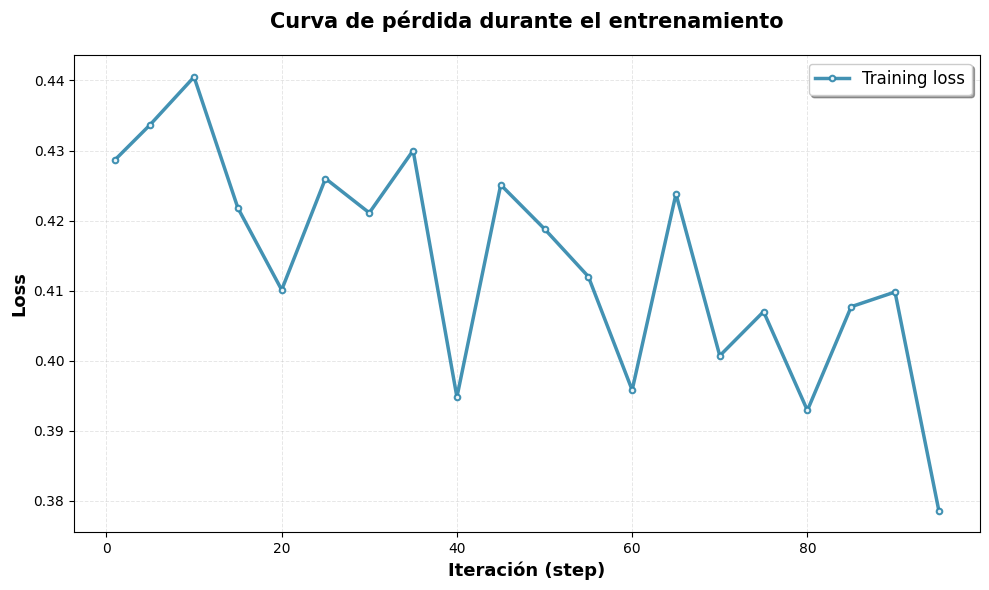

✅ Puntos válidos: 20 de 20
📉 Loss inicial: 0.4287
📉 Loss final: 0.3786
📊 Reducción: 11.7%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrar valores válidos
valid_mask = logs["loss"].notna() & logs["step"].notna()
steps_valid = logs.loc[valid_mask, "step"].values
loss_valid = logs.loc[valid_mask, "loss"].values

plt.figure(figsize=(10, 6))

# Línea principal
plt.plot(steps_valid, loss_valid,
         label="Training loss",
         linewidth=2.5,
         color='#2E86AB',
         alpha=0.9,
         marker='o',
         markersize=4,
         markerfacecolor='white',
         markeredgewidth=1.5,
         markeredgecolor='#2E86AB')

plt.xlabel("Iteración (step)", fontsize=13, fontweight='bold')
plt.ylabel("Loss", fontsize=13, fontweight='bold')
plt.title("Curva de pérdida durante el entrenamiento", fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

print(f"✅ Puntos válidos: {len(steps_valid)} de {len(logs)}")
print(f"📉 Loss inicial: {loss_valid[0]:.4f}")
print(f"📉 Loss final: {loss_valid[-1]:.4f}")
print(f"📊 Reducción: {(1 - loss_valid[-1]/loss_valid[0])*100:.1f}%")


In [ ]:
!python --version

Python 3.12.12


In [ ]:
# 1. Guardar modelo y tokenizer
#trainer.save_model("llama3_lora_simplification_final")
# Guardar local
trainer.model.save_pretrained("llama3_2_3b_pls_lora/adapter")

# Definir versión
VERSION = "v6_T4_simple_10epochs_CE_PROMPT1_1000"  # ← CAMBIAR ESTO CADA VEZ

# Copiar a Drive
!mkdir -p /content/drive/MyDrive/llama3_models
!cp -r llama3_2_3b_pls_lora/adapter /content/drive/MyDrive/llama3_models/adapter_{VERSION}

print(f"✅ Guardado: adapter_{VERSION}")
#tokenizer.save_pretrained("llama3_lora_simplification_final")
print("✅ Modelo guardado")

✅ Guardado: adapter_v6_T4_simple_5epochs_CE_PROMPT1_1000
✅ Modelo guardado


# 4.Generación de Resumenes


In [ ]:
import torch
print("GPU disponible:", torch.cuda.is_available())
print("Dispositivo del modelo:", trainer.model.device)

GPU disponible: True
Dispositivo del modelo: cuda:0


## Preparar Dataset para pasar a DataFrame df_test para la Generación de Texto

Elimna promp y crea source

In [ ]:
print(hf_ds["test"].column_names)
df_test = hf_ds["test"].to_pandas()
print(df_test.columns)

import re
import pandas as pd

def extract_source_from_prompt(prompt):
    """
    Extrae el texto entre 'original text' y 'simplified text' del prompt.
    Robusto ante espacios, mayúsculas y saltos de línea.
    """
    match = re.search(
        r"Input abstract:\s*[:\-–]?\s*(.*?)\s*Output PLS",
        prompt,
        re.IGNORECASE | re.DOTALL
    )
    if match:
        return match.group(1).strip()
    return ""

# Crear columna 'source' desde 'prompt'
df_test["source"] = df_test["prompt"].apply(extract_source_from_prompt)

# Mantener solo columnas necesarias
df_test = df_test[["source", "response"]]

# Mostrar ejemplo de verificación
print(df_test.head(2))

['prompt', 'response']
Index(['prompt', 'response'], dtype='object')
                                              source  \
0  Background\nImaging is commonly performed for ...   
1  Background\nCryptococcal meningitis is a sever...   

                                            response  
0  Interventions for improving the appropriate us...  
1  Treatment for HIV‐associated cryptococcal meni...  


## Generación de texto para el set TEST

## GENERACION

In [ ]:
if "trainer" in locals() and hasattr(trainer, "model"):
    fine_tuned_model = trainer.model.eval()
else:
    fine_tuned_model = model.eval()

In [ ]:
import gc
import torch
from tqdm import tqdm
from difflib import SequenceMatcher
import re



In [ ]:
def generate_simplifications_v2(
    df,
    model,
    tokenizer,
    instr_prompt,
    batch_size=2,
    max_source_tokens=512,
    sim_threshold=0.75,
    verbose=True,
):
    """
    Genera textos simplificados con regeneración multinivel.
    Si el texto generado está vacío, intenta regenerar automáticamente.
    """

    import gc, torch, re
    from tqdm import tqdm
    from difflib import SequenceMatcher

    tokenizer.padding_side = "right"
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.clean_up_tokenization_spaces = True

    model.eval()
    model.config.use_cache = True
    model.config.output_hidden_states = False
    model.config.return_dict = True

    torch.cuda.empty_cache()
    gc.collect()

    if verbose:
        print("\n🚀 Generación iniciada (modo seguro, con detección de vacíos)...")

    # === FUNCIONES AUXILIARES ===
    def truncate_text(text, max_tokens=max_source_tokens):
        tokens = text.split()
        if len(tokens) <= max_tokens:
            return text
        head = tokens[:max_tokens // 2]
        tail = tokens[-max_tokens // 2:]
        return " ".join(head + ["[...]"] + tail)

    def safe_generate(prompts, gen_params):
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1536
        ).to(model.device)

        with torch.inference_mode():
            outputs = model.generate(**inputs, **gen_params)

        texts = tokenizer.batch_decode(
            outputs,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
            errors="replace"
        )
        return texts

    def extract_simplified_text(text):
        match = re.search(r"Output PLS\s*[:\-–]?\s*(.*)", text, re.IGNORECASE | re.DOTALL)
        if match:
            simplified = match.group(1).strip()
        else:
            simplified = text.strip()
        simplified = re.sub(r"<\|endoftext\|>", "", simplified)
        simplified = re.sub(r"\s+", " ", simplified).strip()
        return simplified

    # === PARÁMETROS DE GENERACIÓN ===
    GEN_PARAMS_L1 = {"max_new_tokens": 256, "temperature": 0.7, "top_p": 0.9, "do_sample": False,
                     "num_beams": 1, "repetition_penalty": 1.1,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    GEN_PARAMS_L2 = {"max_new_tokens": 256, "temperature": 1.1, "top_p": 0.85, "do_sample": True,
                     "num_beams": 1, "repetition_penalty": 1.0,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    GEN_PARAMS_L3 = {"max_new_tokens": 256, "temperature": 0.7, "top_p": 0.9, "do_sample": False,
                     "num_beams": 4, "repetition_penalty": 1.1,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    # === PREPARACIÓN ===
    df = df.copy()
    df["source_for_generation"] = df["source"].apply(lambda x: truncate_text(x))
    if verbose:
        print("✅ Columna 'source_for_generation' creada correctamente")

    # === GENERACIÓN PRINCIPAL ===
    generated_texts, is_copy_list, was_regenerated_list = [], [], []
    regeneration_level_list, similarity_scores = [], []
    regeneration_count = 0

    for i in tqdm(range(0, len(df), batch_size), desc="Generando simplificaciones"):
        if i % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        batch_sources = df["source"].iloc[i:i+batch_size].tolist()
        batch_sources_trunc = df["source_for_generation"].iloc[i:i+batch_size].tolist()
        batch_prompts = [instr_prompt.format(source=s) for s in batch_sources_trunc]

        full_texts = safe_generate(batch_prompts, GEN_PARAMS_L1)

        for j, full_text in enumerate(full_texts):
            simplified = extract_simplified_text(full_text)
            source_idx = i + j
            if source_idx >= len(df):
                continue

            # 🔍 --- NUEVO BLOQUE: REGENERACIÓN SI EL TEXTO ESTÁ VACÍO ---
            if not simplified or len(simplified.strip()) == 0:
                if verbose:
                    print(f"⚠️ Texto vacío detectado en índice {source_idx}. Regenerando...")
                single_prompt = instr_prompt.format(source=batch_sources_trunc[j])
                regen_text = safe_generate([single_prompt], GEN_PARAMS_L2)[0]
                simplified = extract_simplified_text(regen_text)
                # Si sigue vacío, prueba con L3
                if not simplified or len(simplified.strip()) == 0:
                    beam_text = safe_generate([single_prompt], GEN_PARAMS_L3)[0]
                    simplified = extract_simplified_text(beam_text)

            # === Calcular similitud y regeneraciones ===
            sim = SequenceMatcher(None, batch_sources[j].lower(), simplified.lower()).ratio()
            is_copy = sim > sim_threshold
            regen_level = 0

            if is_copy:
                regeneration_count += 1
                single_prompt = instr_prompt.format(source=batch_sources_trunc[j])

                regen_text = safe_generate([single_prompt], GEN_PARAMS_L2)[0]
                simplified_regen = extract_simplified_text(regen_text)
                sim_regen = SequenceMatcher(None, batch_sources[j].lower(), simplified_regen.lower()).ratio()

                if sim_regen <= sim_threshold:
                    simplified, sim, is_copy, regen_level = simplified_regen, sim_regen, False, 2
                else:
                    beam_text = safe_generate([single_prompt], GEN_PARAMS_L3)[0]
                    simplified_beam = extract_simplified_text(beam_text)
                    sim_beam = SequenceMatcher(None, batch_sources[j].lower(), simplified_beam.lower()).ratio()

                    if sim_beam <= sim_threshold:
                        simplified, sim, is_copy, regen_level = simplified_beam, sim_beam, False, 3
                    else:
                        if sim_beam < sim_regen:
                            simplified, sim, regen_level = simplified_beam, sim_beam, 3
                        else:
                            simplified, sim, regen_level = simplified_regen, sim_regen, 2

            generated_texts.append(simplified)
            is_copy_list.append(is_copy)
            was_regenerated_list.append(regen_level > 0)
            regeneration_level_list.append(regen_level)
            similarity_scores.append(sim)

    # === GUARDAR RESULTADOS ===
    df["generated_text"] = generated_texts
    df["is_copy"] = is_copy_list
    df["was_regenerated"] = was_regenerated_list
    df["regeneration_level"] = regeneration_level_list
    df["similarity_score"] = similarity_scores

    if verbose:
        print(f"\n✅ Generación completada sin errores de memoria")
        print(f"📊 Total textos: {len(df)} | Regenerados: {sum(was_regenerated_list)} | Copias finales: {sum(is_copy_list)}")
        print(f"Promedio de similitud: {sum(similarity_scores)/len(similarity_scores):.3f}")

    return df


Necesita source y response

In [ ]:
df_out = generate_simplifications_v2(
    df=df_test,
    model=fine_tuned_model,
    tokenizer=tokenizer,
    instr_prompt=INSTR_PROMPT,
    batch_size=2,
)


🚀 Generación iniciada (modo seguro, con detección de vacíos)...
✅ Columna 'source_for_generation' creada correctamente


Generando simplificaciones: 100%|██████████| 50/50 [13:55<00:00, 16.72s/it]


✅ Generación completada sin errores de memoria
📊 Total textos: 100 | Regenerados: 0 | Copias finales: 0
Promedio de similitud: 0.094


In [ ]:
# =====================================================================
# EJEMPLO DE SALIDA SIMPLIFICADA
# =====================================================================
print("\n🧾 Ejemplo de salida simplificada:\n" + "="*50)

# Seleccionamos un ejemplo aleatorio del DataFrame
import random
idx = random.randint(0, len(df_test) - 1)

print(f"\n🔹 Índice: {idx}")
print("\n--- Texto original (source) ---")
print(df_out.loc[idx, "source"][:1000])  # mostramos hasta 1000 caracteres por legibilidad

print("\n--- Texto simplificado generado ---")
print(df_out.loc[idx, "generated_text"])

print("\n" + "="*50)


🧾 Ejemplo de salida simplificada:

🔹 Índice: 81

--- Texto original (source) ---
Background
Chronic fatigue syndrome (CFS) or myalgic encephalomyelitis (ME) is a serious disorder characterised by persistent postexertional fatigue and substantial symptoms related to cognitive, immune and autonomous dysfunction. There is no specific diagnostic test, therefore diagnostic criteria are used to diagnose CFS. The prevalence of CFS varies by type of diagnostic criteria used. Existing treatment strategies primarily aim to relieve symptoms and improve function. One treatment option is exercise therapy. 
Objectives
The objective of this review was to determine the effects of exercise therapy for adults with CFS compared with any other intervention or control on fatigue, adverse outcomes, pain, physical functioning, quality of life, mood disorders, sleep, self‐perceived changes in overall health, health service resources use and dropout. 
Search methods
We searched the Cochrane Common Mental Diso

Algunos modelos de instrucciones (como Alpaca, Mistral, etc.) incluyen el prompt dentro del output.
Puedes limpiarlo fácilmente:

In [ ]:
import re

def extract_response(gen):
    """
    Extrae la parte del texto posterior a 'Simplified text:' (en cualquiera de sus variantes)
    y limpia encabezados residuales tipo '## Background' o 'Output:'.
    """
    # Captura flexible: acepta ###, espacios, o saltos de línea
    match = re.search(r"#+\s*Output PLS\s*[:\-–]?\s*(.*)", gen, flags=re.IGNORECASE | re.DOTALL)
    if match:
        response = match.group(1).strip()
    else:
        response = gen.strip()

    # Limpieza opcional (cabeceras Markdown o Output:)
    response = re.sub(r"^(Output:|#+\s*(Background|Summary|Question|Answer).*)", "", response, flags=re.IGNORECASE).strip()
    return response

df_out["generated_clean"] = df_out["generated_text"].apply(extract_response)






# 6.Métricas


## Evaluación y Métricas



## Librerias de Metricas

In [ ]:
# Extraer el texto después de "Input:"
#df_test["source"] = df_test["prompt"].str.split("### Original text:", n=1).str[-1].str.strip()

# Si tu prompt también tiene "Output:" al final, cortá ahí:
#df_test["source"] = df_test["source"].str.split("### Simplified text:", n=1).str[0].str.strip()

# Verificar
print(df_test["source"].head(1).values[0])

Background
Imaging is commonly performed for musculoskeletal conditions. Identifying interventions to improve the appropriate use of imaging for musculoskeletal conditions could potentially result in improved health outcomes for patients and reduced health care costs. 
Objectives
To determine the effects of interventions that aim to improve the appropriate use of imaging for people with musculoskeletal conditions. 
Search methods
We searched the Cochrane Effective Practice and Organisation of Care Group Specialised Register (June 2007), The Cochrane Central Register of Controlled Trials (The Cochrane Library 2007, Issue 2), MEDLINE (January 1966 to June 2007), EMBASE (January 1980 to June 2007) and CINAHL (January 1982 to June 2007). We also searched reference lists of included studies and relevant reviews. We undertook citation searches of all included studies, contacted authors of included studies, and contacted other experts in the field of effective professional practice. 
Selectio

## Todas las métricas

In [ ]:
# ============================================================================
# LIMPIAR DATAFRAME ANTES DE CALCULAR MÉTRICAS
# ============================================================================

print("🧹 LIMPIANDO DataFrame antes de calcular métricas...")
print("="*80)

# Ver estado actual
print(f"Columnas actuales: {len(df_out.columns)}")

# Identificar columnas de métricas a eliminar
metrics_to_remove = [col for col in df_test.columns if any(keyword in col for keyword in [
    'BERT_', 'AlignScore', 'TextStat_', 'FRE', 'FKGL', 'SMOG',
    'CLI', 'DCRS', 'GFI', 'similarity_score'
])]

print(f"Columnas de métricas a eliminar: {len(metrics_to_remove)}")
for col in metrics_to_remove:
    print(f"   - {col}")

# Eliminar columnas de métricas
df_test = df_test.drop(columns=metrics_to_remove, errors='ignore')

print(f"\n✅ DataFrame limpio: {len(df_test.columns)} columnas")
print("\n📋 Columnas restantes:")
for col in df_test.columns:
    print(f"   - {col}")

print("="*80)

# ============================================================================
# AHORA SÍ, CALCULAR MÉTRICAS DESDE CERO
# ============================================================================

print("\n🔄 Calculando métricas desde cero...")
print("="*80)

# Aquí va tu código de cálculo de métricas
# Por ejemplo:
# 1. BERTScore
# 2. AlignScore
# 3. TextStat
# etc.

print("\n✅ Listo para calcular métricas frescas sin duplicados")

🧹 LIMPIANDO DataFrame antes de calcular métricas...
Columnas actuales: 9
Columnas de métricas a eliminar: 0

✅ DataFrame limpio: 2 columnas

📋 Columnas restantes:
   - source
   - response

🔄 Calculando métricas desde cero...

✅ Listo para calcular métricas frescas sin duplicados


## Metricas Todas

In [ ]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
print(df_out.columns)

Index(['source', 'response', 'source_for_generation', 'generated_text',
       'is_copy', 'was_regenerated', 'regeneration_level', 'similarity_score',
       'generated_clean'],
      dtype='object')


In [ ]:
# ============================================================================
# 📊 PASO 1: CALCULAR MÉTRICAS (BERTScore + TextStat + AlignScore)
# ============================================================================

from bert_score import score as bertscore
import textstat
import pandas as pd
import torch
import transformers
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

EMB_MODEL = "sentence-transformers/all-mpnet-base-v2"  # cambia por modelo biomédico si quieres
DEVICE = "cuda" if (torch and torch.cuda.is_available()) else "cpu"
EMB_BATCH = 256   # reducir si OOM en T4 (prueba 128/64)

'''# Fix para AdamW
if not hasattr(transformers, "AdamW"):
    from torch.optim import AdamW
    transformers.AdamW = AdamW

from alignscore import AlignScore
'''

print("="*80)
print("📊 CALCULANDO MÉTRICAS")
print("="*80)

# --------------------------------------------------------
# 🔧 CONFIGURACIÓN INICIAL
# --------------------------------------------------------
col_ref = "response" #pls
col_gen = "generated_text"  # ← Cambié a generated_text (ajusta si es otro)
col_non_pls="source"

# Crear columna limpia si no existe
if col_gen not in df_out.columns and "generated_text" in df_test.columns:
    df_out["generated_clean"] = df_out["generated_text"].str.strip()
    col_gen = "generated_clean"

print(f"\n✓ Columna de referencia: {col_ref}")
print(f"✓ Columna generada: {col_gen}")
print(f"✓ Total textos: {len(df_out)}")

# --------------------------------------------------------
# 🧩 BERTScore
# --------------------------------------------------------
# --------------------------------------------------------
# 🧩 BERTScore 1 — modelo base (por defecto)
# --------------------------------------------------------
print("\n📊 Calculando BERTScore (modelo base)...")

refs = df_out[col_ref].astype(str).tolist()  # textos de referencia (PLS)
preds = df_out[col_gen].astype(str).tolist()  # textos generados
non_pls = df_out[col_non_pls].astype(str).tolist()  # abstract original

# Primer BERTScore: modelo por defecto ("roberta-large") o idioma "en"
P1, R1, F1_1 = bertscore(preds, refs, lang="en", verbose=False)

df_out["BERT_Precision"] = P1.numpy()
df_out["BERT_Recall"] = R1.numpy()
df_out["BERT_F1"] = F1_1.numpy()

print(f"✅ BERTScore (base) calculado")
print(f"   - Precision media: {P1.mean():.3f}")
print(f"   - Recall media: {R1.mean():.3f}")
print(f"   - F1 media: {F1_1.mean():.3f}")


# --------------------------------------------------------
# 🧩 BERTScore 2 — modelo alternativo o comparación distinta
# --------------------------------------------------------
print("\n📊 Calculando BERTScore (modelo alternativo: Longformer)...")

from evaluate import load
bertscore_alt = load("bertscore")

results_alt = bertscore_alt.compute(
    predictions=preds,
    references=refs,
    model_type="allenai/longformer-large-4096-finetuned-triviaqa",
    lang="en"
)

# Convertir los resultados en listas de precisión, recall y F1
P2 = results_alt["precision"]
R2 = results_alt["recall"]
F1_2 = results_alt["f1"]

# Guardar en df_out con nombres distintos
df_out["BERT2_Precision_Longformer"] = P2
df_out["BERT2_Recall_Longformer"] = R2
df_out["BERT2_F1_Longformer"] = F1_2

print(f"✅ BERTScore (Longformer) calculado")
print(f"   - Precision media: {sum(P2)/len(P2):.3f}")
print(f"   - Recall media: {sum(R2)/len(R2):.3f}")
print(f"   - F1 media: {sum(F1_2)/len(F1_2):.3f}")


# --------------------------------------------------------
# 📚 TextStat (legibilidad y complejidad)
# --------------------------------------------------------
print("\n📚 Calculando métricas TextStat...")

def get_textstat_metrics(text):
    try:
        return {
            "flesch_reading_ease": textstat.flesch_reading_ease(text),
            "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
            "smog_index": textstat.smog_index(text),
            "coleman_liau_index": textstat.coleman_liau_index(text),
            "automated_readability_index": textstat.automated_readability_index(text),
            "dale_chall_readability_score": textstat.dale_chall_readability_score(text),
            "difficult_words": textstat.difficult_words(text),
            "linsear_write_formula": textstat.linsear_write_formula(text),
            "gunning_fog": textstat.gunning_fog(text),
        }
    except:
        return {key: None for key in [
            "flesch_reading_ease", "flesch_kincaid_grade", "smog_index",
            "coleman_liau_index", "automated_readability_index",
            "dale_chall_readability_score", "difficult_words",
            "linsear_write_formula", "gunning_fog"
        ]}

textstat_metrics = df_out[col_gen].apply(get_textstat_metrics)
df_textstat = pd.DataFrame(textstat_metrics.tolist()).add_prefix("TextStat_")

df_out = pd.concat([df_out, df_textstat], axis=1)

print(f"✅ TextStat calculado ({len(df_textstat.columns)} métricas)")

# --------------------------------------------------------
# 🔗 AlignScore o Equivalente Rapido
# --------------------------------------------------------
# -------- SI NO HAY SCORE, CALCULARLO (GPU / batching) --------
print("\n🔗 Calculando AlignScore (versión ligera)...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   Usando: {device}")

def compute_pairwise_align(ref_texts, gen_texts, model_name=EMB_MODEL, batch_size=EMB_BATCH, device=device):
    if SentenceTransformer is None:
        raise ImportError("sentence-transformers no está instalado. Instálalo con: pip install sentence-transformers")
    if len(ref_texts) != len(gen_texts):
        raise ValueError("refs y gens deben tener la misma longitud")

    model = SentenceTransformer(model_name, device=device)
    model.max_seq_length = 512

    def encode_list(texts):
        embs = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding", leave=False):
            batch = texts[i:i+batch_size]
            b_emb = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            b_emb = torch.nn.functional.normalize(b_emb, p=2, dim=1)
            embs.append(b_emb)
        return torch.cat(embs, dim=0)

    refs_emb = encode_list(ref_texts)
    gens_emb = encode_list(gen_texts)
    refs_emb = refs_emb.to(device)
    gens_emb = gens_emb.to(device)

    with torch.no_grad():
        cosines = torch.sum(refs_emb * gens_emb, dim=1).clamp(-1.0, 1.0).cpu().numpy()
    return cosines

# Calcular y guardar
align_scores = compute_pairwise_align(non_pls, preds)
df_out["AlignScore"] = align_scores

print(f"✅ AlignScore calculado (cosine embedding)")
print(f"   - Media: {sum(align_scores)/len(align_scores):.3f}")

print("\n" + "="*80)
print("✅ TODAS LAS MÉTRICAS CALCULADAS")
print("="*80)

# ============================================================================
# 📊 PASO 2: RESUMEN DE MÉTRICAS - TABLA PROFESIONAL
# ============================================================================

from tabulate import tabulate

print("\n🔧 Preparando tablas de resumen...")

# Renombrar TextStat con nombres cortos
textstat_rename = {
    "TextStat_flesch_reading_ease": "FRE",
    "TextStat_flesch_kincaid_grade": "FKGL",
    "TextStat_smog_index": "SMOG",
    "TextStat_coleman_liau_index": "CLI",
    "TextStat_dale_chall_readability_score": "DCRS",
    "TextStat_gunning_fog": "GFI",
}

# Aplicar renombrado
rename_dict = {k: v for k, v in textstat_rename.items() if k in df_out.columns}
df_out_display = df_out.rename(columns=rename_dict)

# Seleccionar columnas de métricas
metric_columns = [
    "BERT_Precision",
    "BERT_Recall",
    "BERT_F1",
    "BERT2_F1_Longformer",
    "AlignScore"
] + [v for v in textstat_rename.values() if v in df_out_display.columns]

# Añadir columnas TextStat no renombradas
other_textstat = [col for col in df_out.columns if col.startswith("TextStat_") and col not in textstat_rename]
metric_columns.extend(other_textstat)

# Crear DataFrame de métricas sin duplicados
df_metrics = df_out_display[metric_columns].copy()
df_metrics = df_metrics.loc[:, ~df_metrics.columns.duplicated()]

print(f"✓ Métricas seleccionadas: {len(df_metrics.columns)} columnas")

# ============================================================================
# ✅ CREAR stats_df
# ============================================================================

stats_df = pd.DataFrame({
    'Mean': df_metrics.mean(numeric_only=True),
    'Std': df_metrics.std(numeric_only=True),
    'Min': df_metrics.min(numeric_only=True),
    'Max': df_metrics.max(numeric_only=True),
    'Median': df_metrics.median(numeric_only=True),
}).T

print(f"✓ stats_df creado: {stats_df.shape}")

# ============================================================================
# 📈 TABLA DE MÉTRICAS POR TEXTO (primeros 10)
# ============================================================================

print("\n" + "="*120)
print("📊 MÉTRICAS POR TEXTO (Primeros 10 ejemplos)")
print("="*120)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.3f}'.format)

print("\n")
print(df_metrics.head(10).to_string())
print("\n" + "="*120)

# ============================================================================
# 📊 ESTADÍSTICAS GLOBALES
# ============================================================================

print("\n" + "="*120)
print("📈 ESTADÍSTICAS GLOBALES")
print("="*120 + "\n")

# Preparar datos para tabulate
table_data = []
for stat_name in ['Mean', 'Std', 'Min', 'Max', 'Median']:
    row = [stat_name] + [f"{val:.3f}" for val in stats_df.loc[stat_name]]
    table_data.append(row)

headers = ['Statistic'] + list(stats_df.columns)

print(tabulate(table_data, headers=headers, tablefmt='grid',
               stralign='center', numalign='center'))
print()

# ============================================================================
# 📊 REFERENCIA COMPARATIVA (Modelos del paper CL4Health 2025)
# ============================================================================

reference_data = [
    ["DeepSeek-R1-7B",        16.99, 22.75, 17.69, 12.31, 14.80, 9.45, 0.7955, 0.8496],
    ["Gemini-1.3-Flash",      9.60,  66.87, 8.75,  9.08,  6.90,  5.94, 0.6333, 0.8474],
    ["GPT-4-32K",            12.48,  48.52, 13.39, 11.20, 10.80, 7.41, 0.7801, 0.8519],
    ["GPT-4o",               11.49,  57.13, 11.16,  9.91,  9.09, 6.88, 0.7383, 0.8527],
    ["GPT-3.5-Turbo-16K",    15.52,  28.08, 17.33, 12.59, 13.91, 8.60, 0.8781, 0.8585],
    ["Llama-3.2-3B",         16.42,  21.96, 18.58, 10.79, 15.73, 9.39, 0.8785, 0.8490],
]

ref_headers = ["Model", "CLI ↓", "FRE ↑", "GFI ↓", "SMOG ↓", "FKGL ↓", "DCRS ↓", "AlignScore ↑", "BERTScore ↑"]

print("\n" + "="*120)
print("📊 TABLA DE REFERENCIA (Valores del paper CL4Health-2025)")
print("="*120 + "\n")

print(tabulate(reference_data, headers=ref_headers, tablefmt="grid",
               stralign="center", numalign="center"))
print()

# ============================================================================
# 🎯 RESUMEN EJECUTIVO
# ============================================================================

print("\n" + "="*100)
print("🎯 RESUMEN EJECUTIVO")
print("="*100)

key_metrics = {
    "Semantic Similarity": {
        "BERT F1": df_metrics["BERT_F1"].mean() if "BERT_F1" in df_metrics.columns else None,
        "AlignScore": df_metrics["AlignScore"].mean() if "AlignScore" in df_metrics.columns else None,
    },
    "Readability": {
        "Flesch Ease (FRE)": df_metrics["FRE"].mean() if "FRE" in df_metrics.columns else None,
        "FK Grade Level": df_metrics["FKGL"].mean() if "FKGL" in df_metrics.columns else None,
        "SMOG Index": df_metrics["SMOG"].mean() if "SMOG" in df_metrics.columns else None,
    },
    "Complexity": {
        "Coleman-Liau": df_metrics["CLI"].mean() if "CLI" in df_metrics.columns else None,
        "Dale-Chall": df_metrics["DCRS"].mean() if "DCRS" in df_metrics.columns else None,
        "Gunning Fog": df_metrics["GFI"].mean() if "GFI" in df_metrics.columns else None,
    }
}

for category, metrics in key_metrics.items():
    print(f"\n📌 {category}:")
    for metric_name, value in metrics.items():
        if value is not None:
            # Emoji según valor
            if "F1" in metric_name or "AlignScore" in metric_name:
                emoji = "✅" if value >= 0.7 else "⚠️" if value >= 0.5 else "❌"
            elif "Flesch" in metric_name or "FRE" in metric_name:
                emoji = "✅" if value >= 60 else "⚠️" if value >= 50 else "❌"
            elif any(x in metric_name for x in ["Grade", "SMOG", "Coleman", "Dale", "Gunning"]):
                emoji = "✅" if value <= 10 else "⚠️" if value <= 12 else "❌"
            else:
                emoji = "📊"

            print(f"   {emoji} {metric_name:.<35} {value:>8.3f}")

print("="*100)

# =====================================================================
# 🎯 RESUMEN EJECUTIVO (con comparación a Llama-3.2-3B)
# =====================================================================

print("\n" + "="*100)
print("🎯 RESUMEN EJECUTIVO (comparado con Llama-3.2-3B)")
print("="*100)

# === 1️⃣ Valores de referencia (Llama-3.2-3B) ===
llama3_ref = {
    "CLI": 16.42,
    "FRE": 21.96,
    "GFI": 18.58,
    "SMOG": 10.79,
    "FKGL": 15.73,
    "DCRS": 9.39,
    "AlignScore": 0.8785,
    "BERT_F1": 0.849
}

# === 2️⃣ Tu resumen de métricas ===
key_metrics = {
    "Semantic Similarity": {
        "BERT_F1": df_metrics["BERT_F1"].mean() if "BERT_F1" in df_metrics.columns else None,
        "AlignScore": df_metrics["AlignScore"].mean() if "AlignScore" in df_metrics.columns else None,
    },
    "Readability": {
        "FRE": df_metrics["FRE"].mean() if "FRE" in df_metrics.columns else None,
        "FKGL": df_metrics["FKGL"].mean() if "FKGL" in df_metrics.columns else None,
        "SMOG": df_metrics["SMOG"].mean() if "SMOG" in df_metrics.columns else None,
    },
    "Complexity": {
        "CLI": df_metrics["CLI"].mean() if "CLI" in df_metrics.columns else None,
        "DCRS": df_metrics["DCRS"].mean() if "DCRS" in df_metrics.columns else None,
        "GFI": df_metrics["GFI"].mean() if "GFI" in df_metrics.columns else None,
    }
}

# === 3️⃣ Mostrar métricas comparadas ===
for category, metrics in key_metrics.items():
    print(f"\n📌 {category}:")
    for metric_name, value in metrics.items():
        if value is not None:
            # Valor de referencia (si existe)
            ref_val = llama3_ref.get(metric_name, None)

            # Emoji según desempeño relativo
            if "F1" in metric_name or "AlignScore" in metric_name:
                emoji = "✅" if value >= 0.7 else "⚠️" if value >= 0.5 else "❌"
            elif "FRE" in metric_name:
                emoji = "✅" if value >= 60 else "⚠️" if value >= 50 else "❌"
            elif any(x in metric_name for x in ["Grade", "SMOG", "CLI", "DCRS", "GFI", "FKGL"]):
                emoji = "✅" if value <= 10 else "⚠️" if value <= 12 else "❌"
            else:
                emoji = "📊"

            # Mostrar línea con comparación
            if ref_val is not None:
                diff = value - ref_val
                arrow = "⬆️" if diff > 0 else "⬇️" if diff < 0 else "➡️"
                print(f"   {emoji} {metric_name:<20} {value:>8.3f}  ({arrow} vs Llama3 {ref_val:>8.3f})")
            else:
                print(f"   {emoji} {metric_name:<20} {value:>8.3f}")

print("="*100)
# ============================================================================
# 💾 EXPORTAR A CSV
# ============================================================================

df_metrics.to_csv("metrics_complete.csv", index=False)
stats_df.T.to_csv("metrics_summary.csv")

print("\n💾 Tablas guardadas:")
print("   - metrics_complete.csv (todas las métricas por texto)")
print("   - metrics_summary.csv (estadísticas resumidas)")
print()

📊 CALCULANDO MÉTRICAS

✓ Columna de referencia: response
✓ Columna generada: generated_text
✓ Total textos: 100

📊 Calculando BERTScore (modelo base)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ BERTScore (base) calculado
   - Precision media: 0.828
   - Recall media: 0.809
   - F1 media: 0.818

📊 Calculando BERTScore (modelo alternativo: Longformer)...


config.json:   0%|          | 0.00/866 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Input ids are automatically padded to be a multiple of `config.attention_window`: 512


✅ BERTScore (Longformer) calculado
   - Precision media: 0.796
   - Recall media: 0.770
   - F1 media: 0.782

📚 Calculando métricas TextStat...
✅ TextStat calculado (9 métricas)

🔗 Calculando AlignScore (versión ligera)...
   Usando: cuda


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ AlignScore calculado (cosine embedding)
   - Media: 0.739

✅ TODAS LAS MÉTRICAS CALCULADAS

🔧 Preparando tablas de resumen...
✓ Métricas seleccionadas: 14 columnas
✓ stats_df creado: (5, 14)

📊 MÉTRICAS POR TEXTO (Primeros 10 ejemplos)


   BERT_Precision  BERT_Recall  BERT_F1  BERT2_F1_Longformer  AlignScore     FRE   FKGL   SMOG    CLI   DCRS    GFI  TextStat_automated_readability_index  TextStat_difficult_words  TextStat_linsear_write_formula
0           0.867        0.861    0.864                0.838       0.972  19.917 14.249 15.470 16.475 12.371 17.935                                14.983                        59                           9.000
1           0.885        0.809    0.845                0.820       0.881 -16.467 22.512 20.737 20.946 14.048 24.771                                23.858                        29                          23.500
2           0.825        0.760    0.791                0.740       0.008  65.567  7.965 10.126  8.671  5.933  6.200         

In [ ]:
import textwrap
import random

# =====================================================================
# EJEMPLO DE SALIDA SIMPLIFICADA
# =====================================================================
print("\n🧾 Ejemplo de salida simplificada:\n" + "="*50)

# Seleccionamos un ejemplo aleatorio del DataFrame
idx = random.randint(0, len(df_test) - 1)

print(f"\n🔹 Índice: {idx}")

# Función auxiliar para mostrar texto con ancho fijo y saltos de línea
def mostrar_texto_formateado(texto, ancho=150):
    # Reemplaza saltos de línea escapados por saltos reales, si los hay
    texto = texto.replace("\\n", "\n")
    # Divide el texto en líneas y aplica textwrap a cada una
    lineas = []
    for linea in texto.splitlines():
        # Ajusta cada línea a máximo 'ancho' caracteres
        lineas.extend(textwrap.wrap(linea, width=ancho, replace_whitespace=False) or [""])
    print("\n".join(lineas))

# Texto original (hasta 1000 caracteres)
print("\n--- Texto original (source) ---")
mostrar_texto_formateado(df_out.loc[idx, "source"][:1000], ancho=150)

# Texto simplificado generado
print("\n--- Texto simplificado generado ---")
mostrar_texto_formateado(df_out.loc[idx, "generated_text"], ancho=150)

print("\n" + "="*50)



🧾 Ejemplo de salida simplificada:

🔹 Índice: 14

--- Texto original (source) ---
Background
Memory problems are a common cognitive complaint following stroke and can potentially affect ability to complete functional activities. Cognitive
rehabilitation programmes either attempt to retrain lost or poor memory functions, or teach patients strategies to cope with them.
Some studies have reported positive results of cognitive rehabilitation for memory problems, but the results obtained from previous systematic reviews
have been less positive and they have reported inconclusive evidence. This is an update of a Cochrane review first published in 2000 and most recently
updated in 2007.
Objectives
To determine whether participants who have received cognitive rehabilitation for memory problems following a stroke have better outcomes than those
given no treatment or a placebo control.
The outcomes of interest were subjective and objective assessments of memory function, functional ability, mood

In [ ]:

# Filtrar los casos con AlignScore < 0.3
low_align = df_out[df_out["AlignScore"] < 0.3]

# Mostrar cuántos hay
print(f"🧮 {len(low_align)} ejemplos con AlignScore < 0.3\n")

# Iterar sobre los primeros 10 ejemplos
for i, row in enumerate(low_align[["source", "response", "generated_text", "AlignScore"]].head(10).itertuples(), start=1):
    print(f"\n🔹 Ejemplo {i} | AlignScore: {row.AlignScore:.3f}")
    print("=" * 150)

    # Texto original (source)
    print("\n--- Texto original (source) ---")
    print(textwrap.fill(row.source.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Respuesta de referencia (ground truth)
    print("\n--- Resumen de referencia (response) ---")
    print(textwrap.fill(row.response.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Texto generado por el modelo
    print("\n--- Texto simplificado generado ---")
    print(textwrap.fill(row.generated_text.replace("\\n", "\n"), width=150, replace_whitespace=False))

    print("-" * 150)


🧮 11 ejemplos con AlignScore < 0.3


🔹 Ejemplo 1 | AlignScore: 0.008

--- Texto original (source) ---
Background
Nasal continuous positive airway pressure (NCPAP) is a strategy for maintaining positive airway pressure throughout the respiratory cycle
through the application of bias flow of respiratory gas to an apparatus attached to the nose. Treatment with NCPAP is associated with decreased risk
of mechanical ventilation and might be effective in reducing chronic lung disease. Nasal intermittent positive pressure ventilation (NIPPV) is a form
of noninvasive ventilation during which patients are exposed intermittently to higher levels of airway pressure, along with NCPAP through the same
nasal device. 
Objectives
To examine the risks and benefits of early NIPPV versus early NCPAP alone for preterm infants at risk of or in respiratory
distress within the first hours after birth. 
Primary endpoints are respiratory failure and the need for intubated ventilatory support during the
first we

In [ ]:
import textwrap

for i, text in enumerate(df_out["generated_clean"].head(10), start=1):
    print(f"\n🔹 Ejemplo {i}:")
    print(textwrap.fill(text, width=150))  # wrap de 150 caracteres por línea
    print("-" * 150)


🔹 Ejemplo 1:
#1. Plain Title: Improving the Use of Imaging for Musculoskeletal Conditions #2. Rationale: This study aims to evaluate the effectiveness of different
types of interventions on the use of imaging for musculoskeletal conditions. #3. Trial Design: Randomized controlled trial, Non-randomized controlled
clinical trial, Interrupted Time-series Analysis #4. Results: Twenty-eight studies were identified from electronic databases and handsearches. Most
studies were conducted in North America and Europe. All but one study had been published between 1999-2018. There were 28 studies evaluating
interventions aiming to improve the use of imaging for musculoskeletal conditions. The majority of these studies were for the management of
osteoporosis or low back pain, and most evaluated interventions aimed at health professionals. To improve the use of imaging in the management of
osteoporosis, the effect of any type of intervention compared to no-intervention controls was modest (absolute